In [ ]:
pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 8.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import unidecode
import string
import random
import time
import math
import os
import argparse
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

In [ ]:
# Reading and un-unicode-encoding data

all_characters = string.printable
n_characters = len(all_characters)

def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

# you know what it does, keep in mind it is not a dict tho :)
def create_dictionary(text):
    special_characters = [' ', ':', '\n', ',', '.', '?', "'", ';', '!', '-', '&']

    dictionary = []
    dataset = []

    j = 0
    for i in range(len(text)):
        char = text[i]
        if char in special_characters:
            word = text[j:i]
            if i == j:
                word = text[j:i+1]
                
            if char not in dictionary:
                dictionary.append(char)
                
            if word not in dictionary:
                dictionary.append(word)
                
            if i != j:
                charInd = dictionary.index(char)
                wordInd = dictionary.index(word)
                dataset.append([wordInd])
                dataset.append([charInd])
            else:
                wordInd = dictionary.index(word)
                dataset.append([wordInd])
            
            j = i+1
        continue

    return dictionary, dataset

    
# Turning a string into a tensor

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = dictionary.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:

filename = "/content/shakespeare.txt"
text = read_file(filename)[0]
dictionary, dataset = create_dictionary(text)

In [ ]:
class WordRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(WordRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [ ]:
# finds all whole words in the random chunk?
def findChunk(start_index, chunk_len):
    file_chunk = file[start_index:]
    # print("len(file_chunk)",len(file_chunk))
    special_characters = [' ', ':', '\n', ',', '.', '?', "'", ';', '!', '-', '&']
    chunk = []
    i = 0
    j = 0

    while len(chunk) <= chunk_len:
    # for i in range(len(text)):
        # print("i",i)
        char = file_chunk[i]
        # print("char i",char,i)
        if char in special_characters:
            word = file_chunk[j:i]
            # print("if",word)
            if i == j:
                word = file_chunk[j:i+1]
                
            if char in dictionary:
                # print("found char:",char)
                chunk.append(char)
                
            if word in dictionary:
                # print("found word:",word)
                chunk.append(word)
            
            j = i+1
        i += 1
        continue

    if len(chunk) > chunk_len+1:
        chunk.pop()

    return chunk

In [ ]:
def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, file_len - chunk_len*10)
        # end_index = start_index + chunk_len + 1
        chunk = findChunk(start_index, chunk_len)
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    # print("inp",inp)
    # print("target",target)
    inp = Variable(inp)
    target = Variable(target)
    if cuda:
        inp = inp.cuda()
        target = target.cuda()
    return inp, target

def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    if cuda:
        hidden = hidden.cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
    # for c in [0]:

        # print ("inp[:,c]:", inp[:,c])
        # print ("hidden:",hidden)

        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

def save():
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    torch.save(decoder, save_filename)
    print('Saved as %s' % save_filename)

In [ ]:
def sentence_tensor(string):
    word_tensor = []
    special_characters = [' ', ':', '\n', ',', '.', '?', "'", ';', '!', '-', '&']
    j = 0
    i = 0
    while i < len(string):
        char = string[i]
        if char in special_characters:
            word = 0
            if i == j:
                word = string[j:i+1]
                wordInd = dictionary.index(word)
                word_tensor.append(wordInd)
            else:
                word = string[j:i]
                wordInd = dictionary.index(word)
                charInd = dictionary.index(char)
                word_tensor.append(wordInd)
                word_tensor.append(charInd)
            
            j = i+1
        i += 1
    
    if(j != i):
        word = string[j:i+1]
        wordInd = dictionary.index(word)
        word_tensor.append(wordInd)
    tensor = torch.tensor(word_tensor).long()
    return tensor

In [ ]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(sentence_tensor(prime_str).unsqueeze(1))
    predicted = prime_str
    
    # Use priming string to "build up" hidden state
    for p in range(len(prime_input) - 1):
        inp = torch.unsqueeze(prime_input[p,:], dim=1)
        out, hidden = decoder(inp, hidden)
    
    #hidden = (Variable(hidden[0].detach().to(device)), Variable(hidden[1].detach().to(device)))
    
    inp = torch.unsqueeze(prime_input[-1,:], dim=1)
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_word = dictionary[top_i]
        predicted += predicted_word
        inp = Variable(sentence_tensor(predicted_word).unsqueeze(1))
       
        if cuda:
            inp = inp.cuda()

    return predicted

In [ ]:
# define args
filename = "shakespeare.txt"
n_epochs = 2000
model = "gru"
print_every = 100
hidden_size = 50
n_layers = 2
learning_rate = 0.01
chunk_len = 50
batch_size = 100
shuffle = True
cuda = False

n_characters = len(dictionary)

file, file_len = read_file(filename)

# Initialize models and start training
decoder = WordRNN(
    n_characters,
    hidden_size,
    n_characters,
    model=model,
    n_layers=n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

Training for 2000 epochs...


  5%|▌         | 100/2000 [02:32<44:45,  1.41s/it]

 31s (100 5%) 3.9829]
WhopentunavoideddroppercurrishmountinstigationmurderersSaddleforetells his
your
  
   in    
' 'Ready .
 fair in
famine,to   
 at      !my And 
,here
  will   ,this his 
 your Can  r,I:and 
 
 d in EDWARD  
   



 10%|█         | 200/2000 [04:57<48:26,  1.61s/it]

 57s (200 10%) 3.8380]
WhobarricadoscolddrumsindifferentlypredecessorschurchmencomelybreederObedienceEnrichUncharitablyfamishBredtrapptetchyoratorOxfordshireblotsgenerations  on   and
  night



 she
a you

 more get hear

'be so then       or   so and may country he yours be,win
 
  II   the And comest
 ,forth 



 15%|█▌        | 300/2000 [07:22<40:40,  1.44s/it]

 21s (300 15%) 3.6157]
Whoshootsewinggottenaskance  villain d.I .the   be
my slew
me as
I so
have'How They noble
thou 
   you O to you
From,to
 
, ,be   thee contrive:GRUMIO   gentle
fear,there'


   I
so that I CORIOLANUS;me    



 20%|██        | 400/2000 [09:45<37:48,  1.42s/it]

 45s (400 20%) 3.5505]
Whountruthsometimeunbowr   in the   er not thy be,The  .and  
found gone
port
not Citizen
 

 I cause night I it my my You RICHARD the Johns I
your is and
their , 

  us
have the,that  'follows RICHARD
your
life  



 25%|██▌       | 500/2000 [12:12<38:04,  1.52s/it]

 12s (500 25%) 3.4653]
WhoRememberspouseaidlesssurceaseshepherdstrudgefifthfeelinglyo:
  
To
with of
is be his And
Where Whitsun my the
curse
with
How And and with a our;it  
If it you Being
nor make sweetheart and you:This   do O any
he ' their,the  .the  
is
 



 30%|███       | 600/2000 [14:37<35:20,  1.51s/it]

 37s (600 30%) 3.4219]
Whozodiacscleansedfortifyed






.e


:The:



:O



:the





:And
 
I
mechanics
thee can Shall by your s the Come

 sorrow of to
Come of,power
 
.aspect !
that
smallest sleep not Farewell ask be?to: 



 35%|███▌      | 700/2000 [17:00<31:12,  1.44s/it]

 0s (700 35%) 3.4162]
Whoconsequencemarvellcrossedruddinessr



























et
If
catch the
my,re

,this.


















,me
!our t
this To he
lands
shall Stands A wife thee Gentlemen fear That  



 40%|████      | 800/2000 [19:25<28:13,  1.41s/it]

 25s (800 40%) 3.4119]
WhoHelenan'I.LEONTES
:












:Can
That:ale






,And  
my his bloody sir until?way





 s That,away   the my thither,Bristol   the;alone
 
,to   time not it in
she
let I  



 45%|████▌     | 900/2000 [21:51<29:25,  1.61s/it]

 51s (900 45%) 3.3670]
Whoshoedotedragonsboastse












:And:





 charge
prick
and
O.In



:And 
:Even.  
And the of thee We this on own on.VINCENTIO







 my s that
 !ELIZABETH  
down Why,most ,until  



 50%|█████     | 1000/2000 [24:15<24:50,  1.49s/it]

 15s (1000 50%) 3.2838]
WhoAUFIDIUSdealingsdrawnm



 we
Is
I own There
this sith
my upper
eager,my  
and myo,them   s!pounds;
 

 and than a of- not sir then,I

 wealth
 the and
With high
That,that   mothers my,quam




:I  



 55%|█████▌    | 1100/2000 [26:40<20:56,  1.40s/it]

 40s (1100 55%) 3.2113]
WhofitnessVouchsafeUnlawfullyreftstepsVexMeltingmcomingHidestMarcianssharpscompaniese



:And



:And:




 And'precise loss Make
To the gate
Or Gentleman than,this   To feels;be   as,cannot   of
and as they saucy,alone

 violet has,shroud   By and and.arrest 



 60%|██████    | 1200/2000 [29:04<18:39,  1.40s/it]

 4s (1200 60%) 3.1851]
WhoPinsblotspaintere:their

 That have your For r gesture to make
Angelica them And of endless,now

 to That and my boar THOMAS That to merriment a amongst the
trim love And from of That for
ean'r Misguide makes a My,Insolent

 my true And'disburden 



 65%|██████▌   | 1300/2000 [31:30<18:12,  1.56s/it]

 30s (1300 65%) 3.0633]
WhoGraciouscollarsm   and to
men issue As or the and'

 to bear a will Your but are of the
together a service to you She you.him



 Be is,lost   and how let That the I you in.come



:Nurse

:me   



 70%|███████   | 1400/2000 [33:54<14:23,  1.44s/it]

 54s (1400 70%) 3.1081]
WhosavagenessYouprotect;


 And should my habiliments the man your hate,odd

 But virtuous as heart The ,demands   my blood the.coming



:YORK

 Here gait by what,marry   but of call fool And
argument not like I more to forsworn is both by 



 75%|███████▌  | 1500/2000 [36:17<11:37,  1.40s/it]

 17s (1500 75%) 2.9920]
WhoEraveningshrugsobriveSormusclescertapestryr
And,And,


 And And And And For And To so As,din

 And And'In s,goddess ,

 For And And Let And And And That And And That For And Is And
by And For For And And And 



 80%|████████  | 1600/2000 [38:41<09:10,  1.38s/it]

 41s (1600 80%) 2.9963]
WhoscentspreadingoursswallowedbecomestpriceEEqualCleargarment
Ay And Then The me For That.morrow

,death  ,Then ,linger   I devise I and sake,Nay

 Which my heard I thee and more by
be But she From in Harry thou my,Polixenes   If for
I thy hand  



 85%|████████▌ | 1700/2000 [41:04<07:26,  1.49s/it]

 4s (1700 85%) 3.0041]
WhoFoulEmbarquementsAndMakeWhybeweptSupposingSospawnedmarchesr  ,him,

,Now   you The own presenteth And so thy,grumblings   know
For To cordial,number   nor unlawful.sleep

 In it have have this?king



:LEONTES

 I and?her



 the does him the sir 



 90%|█████████ | 1800/2000 [43:29<05:04,  1.52s/it]

 29s (1800 90%) 3.0086]
Whoechocurdiedtemperatead
No,O   you Our master and any a
good as before for As of no
find and is this best soon the;foes   the,Well   and I
but And trod which enter in.great



:Clown

,Now   a   I to to 



 95%|█████████▌| 1900/2000 [45:53<02:25,  1.46s/it]

 52s (1900 95%) 2.9690]
WhoUnhappyYetAndIfBeStepMaliciouslyapsoughtr

 And But in waking to with liberties But And But Therefore That,Jewry

 And,suggest   as And himself
wrath both That Your - And doth For And wind For And my
tongue And Than him,time  .common,


 For his 



100%|██████████| 2000/2000 [48:17<00:00,  1.45s/it]

 16s (2000 100%) 2.8773]
WhoNobletriper



:GLOUCESTER

:Nay :Then   I is:lord,


 I confidence' ll they:what  :done:


 That kill,Immaculate   as I if rebel
There:Warwick   and God I I whom us
Half kept,presses  ,master,


 To much  

Saving...
Saved as shakespeare.pt


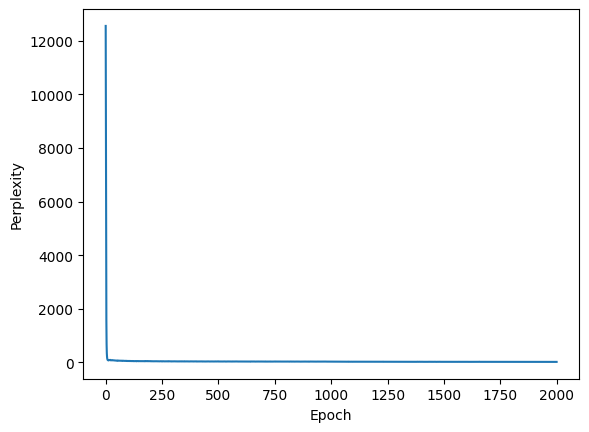

In [ ]:
if cuda:
    decoder.cuda()

start = time.time()
all_losses = []
loss_avg = 0

perplexities = []

try:
    print("Training for %d epochs..." % n_epochs)
    for epoch in tqdm(range(1, n_epochs + 1)):
        loss = train(*random_training_set(chunk_len, batch_size))
        loss_avg += loss
        perplexities.append(math.exp(loss))

        if epoch % print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
            print(generate(decoder, 'Who', 100, cuda=cuda), '\n')

    print("Saving...")
    save()

except KeyboardInterrupt:
    print("Saving before quit...")
    save()


plt.plot(perplexities)
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.show()

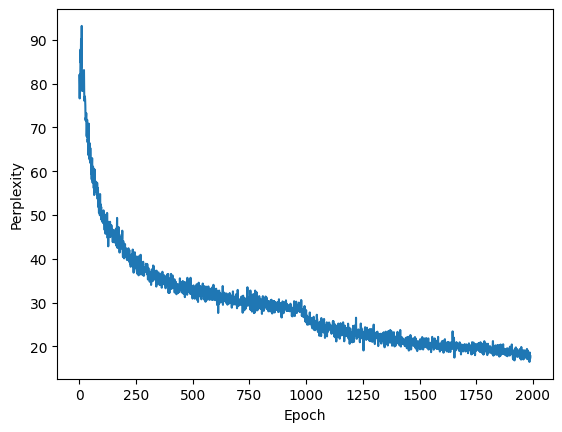

In [ ]:
# if we ignore some of the first epochs we get a much clearer graph
plt.plot(perplexities[10:])
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.show()

In [ ]:
import string
import random

def randomString(len):
    s = ""
    for i in range(len):
        s = s + random.choice(string.printable)
    return s

In [ ]:
decoder = torch.load("shakespeare.pt")

with open('task4_the.txt', 'w') as f:
    for i in range(3):
        prime_string = "The"
        f.write("====== Prime string: " +prime_string + " ======\n")
        f.write(generate(decoder, prime_str=prime_string))
        f.write("\n\n")

In [ ]:
with open('task4_dot.txt', 'w') as f:
    for i in range(3):
        prime_string = "."
        f.write("====== Prime string: " + prime_string +" ======\n")
        f.write(generate(decoder, prime_str=prime_string))
        f.write("\n\n")

In [ ]:
with open('task4_which.txt', 'w') as f:
    for i in range(3):
        prime_string = "which is,"
        f.write("====== Prime string: " + prime_string +" ======\n")
        f.write(generate(decoder, prime_str=prime_string))
        f.write("\n\n")

In [ ]:
with open('task4_blah.txt', 'w') as f:
    for i in range(3):
        prime_string = "blah blah blah"
        f.write("====== Prime string: "+ prime_string + " ======\n")
        f.write(generate(decoder, prime_str=prime_string))
        f.write("\n\n")

ValueError: ignored